# Bayesian classification

In [1]:
# make sure the notebook reloads the module each time we modify it
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import classification_with_solutions as cl
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as sklp
import sklearn.metrics as sklm
import numpy as np
import numpy.random as npr
import pymc3 as pm
import matplotlib.pyplot as plt

## Preparing data and utilities

In [44]:
# load synthetic data for sanity checks, otherwise load wine_data
sanity_check = False
if sanity_check:
    d = 2
    N = 200
    X = npr.randn(N*d).reshape((N,d)) 
    theta = np.array([[-1,0,1]]*d)
    b = np.array([-.5,0,.5]).reshape((1,3))
    weights = np.exp( b + X.dot(theta) )
    weights /= weights.sum(axis=1)[:,np.newaxis]
    y = np.array([npr.choice(3, p=weights[i], size=1)[0] for i in range(N)])
    print("generated synthetic data with theta=", theta, "and b=", b)
else:
    X, y = load_wine(return_X_y=True)
    print("loaded the wine dataset")
    
sample_size, dimension = X.shape
print("sample size, dimension=", sample_size, dimension)
print("class labels are", np.unique(y))

loaded the wine dataset
sample size, dimension= 178 13
class labels are [0 1 2]


**Question:** perform a PCA, and plot the projection onto the first two PCs. Color your points by class. How easy does the classification task look like?

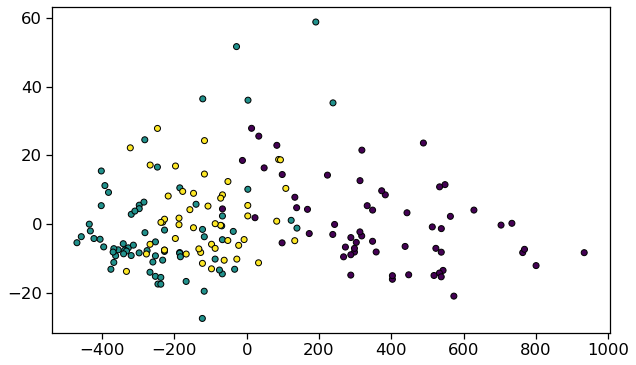

In [45]:
# Quick PCA for visualization
ax = cl.perform_and_visualize_PCA(X, y)

This is a classification task with 3 classes. The dimension $d$ is pretty high for such a small sample size $n$, it is naturally a task that calls for a Bayesian approach. In the following, we'll fit a simple three-class logistic regression. More precisely, we'll take $b\in\mathbb{R}^3$, $\theta_k\in\mathbb{R}^d$ for $k=0,1,2$ and $y\vert x,\theta, b$ to be multinomial with parameters that depend smoothly on $x^T\theta$. More precisely, we consider
$$
p(y = k \vert x, b, \theta) \propto e^{b_k+\theta_k^T x}.
$$

**Question:** Give the DAG for the above multinomial regression model.

**Question:**  What loss function do you want to take?

Since we ultimately want to compare the posterior marginals of different components of $b$ and $\theta$, it is useful to standardize the features. 

In [46]:
X = sklp.scale(X)
print(
    "Now every column of X has mean", np.round(np.mean(X[:,0]), 2), 
    "and variance", np.round(np.var(X[:,0]), 2)
)

Now every column of X has mean 0.0 and variance 1.0


We will also want to predict some unknown labels, so let's keep a test set apart. Be careful that comparing average prediction errors with such a small dataset is irrelevant: it is unlikely that they will be good estimators of the generalization error. We will thus just look at confusion matrices and check that our classifiers are not completely off.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, random_state=3)

## A simple MAP baseline

Try first with `scikit-learn`'s logistic regression. Check out the `multinomial`option, and note how $\ell_2$ regularization is applied by default, at least in the current version (0.22.2).

**Question:** The output of sklearn is thus a MAP estimate, but for what prior? What about the other possible values of the `penalty` option?

In [48]:
skl_intercept, skl_coeffs, skl_predictions = cl.get_sklearn_results(
    X_train, y_train, X_test)

In [49]:
# How good are the predicitions?
confusion_matrix = sklm.confusion_matrix(y_test, skl_predictions)
print(confusion_matrix)

[[15  0  0]
 [ 0 13  1]
 [ 0  0  7]]


In [50]:
# What's the MAP value for the parameters?
print(skl_intercept)
print(skl_coeffs)

[ 0.23719583  0.62298738 -0.86018321]
[[ 0.79258064  0.10642156  0.36620692 -0.80199259  0.01174634  0.26002823
   0.53653755 -0.29828906  0.15707007  0.22733996  0.0162977   0.6421469
   0.92748817]
 [-1.00000894 -0.45390397 -0.73135242  0.39166623  0.02357634  0.11254544
   0.3291608   0.08339901  0.05439956 -1.03688925  0.58460044  0.07565013
  -1.042674  ]
 [ 0.2074283   0.34748241  0.3651455   0.41032636 -0.03532267 -0.37257367
  -0.86569835  0.21489004 -0.21146963  0.80954929 -0.60089814 -0.71779703
   0.11518583]]


## Now we go Bayesian

**Question:** What priors do you want to try? *Hint: make sure the MAP of sklearn is not outside the support of your prior.*

**Question:** Now write your DAG in pymc format, and sample it using NUTS. Put your code in the companion Python file, to make the following line work. Note how there are now two outputs: `trace` and `ppc`. For now just care about `trace` and return whatever for `ppc`, we'll come back to it later on.

In [51]:
map_estimate, trace = cl.get_logistic_results(X_train, y_train, X_test)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta2, theta1, theta0, b]
Sampling 4 chains: 100%|██████████| 10000/10000 [01:41<00:00, 98.69draws/s]
/Users/rbardenet/opt/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -48.327, ||grad|| = 0.18096: 100%|██████████| 21/21 [00:00<00:00, 282.49it/s]  


In [52]:
# print MAP and compare with sklearn's output
print("b", map_estimate['b'], skl_intercept)
print("theta0", map_estimate['theta0'], skl_coeffs[0])
print("theta1", map_estimate['theta1'], skl_coeffs[1])

b [ 0.05554888  0.34850275 -0.40405163] [ 0.23719583  0.62298738 -0.86018321]
theta0 [ 0.81059519  0.13631074  0.39440867 -0.79910517  0.0148366   0.25061482
  0.51104242 -0.28209383  0.12467089  0.24490938 -0.01002073  0.59928371
  0.94219027] [ 0.79258064  0.10642156  0.36620692 -0.80199259  0.01174634  0.26002823
  0.53653755 -0.29828906  0.15707007  0.22733996  0.0162977   0.6421469
  0.92748817]
theta1 [-1.04131327 -0.44852857 -0.72888057  0.4046841   0.03005326  0.0886161
  0.30837373  0.11614232 -0.00237806 -1.13658219  0.56169493  0.03807169
 -1.08788539] [-1.00000894 -0.45390397 -0.73135242  0.39166623  0.02357634  0.11254544
  0.3291608   0.08339901  0.05439956 -1.03688925  0.58460044  0.07565013
 -1.042674  ]


In [57]:
pm.summary(trace, var_names=['b', 'theta0', 'theta1', 'theta2'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b__0,-0.077106,0.777444,0.006671,-1.555981,1.465588,11750.534688,0.999868
b__1,0.632933,0.766431,0.006961,-0.822630,2.181231,10330.978435,0.999878
b__2,-0.585603,0.812568,0.007370,-2.188559,0.981968,9880.346317,0.999791
theta0__0,1.086561,0.826687,0.006864,-0.475784,2.716687,12159.924097,0.999765
theta0__1,0.182935,0.761451,0.007810,-1.289659,1.672411,8922.250314,1.000364
theta0__2,0.546725,0.757338,0.008700,-0.908326,2.068056,9179.513981,1.000235
theta0__3,-1.140024,0.781642,0.007448,-2.605589,0.450031,11517.828996,0.999993
theta0__4,-0.038576,0.749679,0.009494,-1.468145,1.465728,8527.385655,0.999877
theta0__5,0.330998,0.854176,0.007883,-1.418346,1.932998,10976.001273,0.999893
theta0__6,0.692701,0.865911,0.008319,-0.994298,2.370144,10990.320316,1.000072


**Question:** Check how well you chain has mixed.
*Hint: remember the three convergence diagnostics (visual inspection, Gelman-Rubin, Geweke).* 

**Question:** Plot credible intervals on the parameters. How big are they? Was that expected? Also, compare what happens across the three classes.

**Question:** How would you force $\theta$ to be sparse?

## Making predictions
Now let's us predict the labels of the held out "test" dataset. 

**Question:** how do we do this as good Bayesians, now that we have a posterior sample? *Hint: check your course notes for the keyword ``posterior predictive"*.

**Question:** implement the Bayes rule for predictions (actually approximate Bayes rule, since you're going to use the MCMC sample in `trace`). Once you have a posterior predictive sample, find the argmax for each test point, and print the confusion matrix.

**Answer:** so you should have figured out that, if we use the 0/1 loss for prediction, we will classify a test sample $x^*$ by maximizing the posterior predictive, i.e., 
$$ 
y^*\in \arg\max_{y\in\{0,1,2\}} p(y\vert x^*) = \arg\max \int p(y\vert x^*, \theta, b) ~\mathrm{d} p(\theta, b\vert \text{train set}) 
$$

In [54]:
# I ended up making predictions in a different function
predictions = cl.predict(trace, X_test)

In [55]:
confusion_matrix = sklm.confusion_matrix(y_test, predictions)
print(confusion_matrix) # compare that to sklearn's confusion matrix above

[[15  0  0]
 [ 1 12  1]
 [ 0  1  6]]
